# 1. Exploration du data_cars et modélisation
## Objectifs :
* Comprendre les données
* Développer une première stratégie de modilisation

## Plan :
1. Analyse de forme
2. Pre-processing
        2.1. Champs Mileage, Online et Description
        2.2. Champs 'version'
        2.3. Champs 'option'
        2.4. Champs 'couleur'
3. Analyse des données manquantes
4. Analyse univariable
       4.1. Les données manquantes
       4.2. Visualisation de la target
       4.3. Visualisation des variables numériques
       4.4. Visualisation des variables qualitatives
5. Analyse bivariable
       5.1. Les variables numériques
       5.2. La variable 'Fuel'
       5.3. La variable 'Gearbox'
6. Modelisation
       6.1. Définition de la metrique MAPE
       6.2. Définition des transformations de variables
       6.3. Selection d'un échantillon (30% du dataset initial)
       6.4. Selection des features
       6.5. Entrainement de plusieurs modèles
       6.6. Ajout de la feature 'couleur_dominante'
       6.7. Hyper-paramètre n_estimators=100

7. Conclusion
8. Prochaines étapes 

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import re
pd.set_option('max_colwidth', 10000)
pd.set_option('display.max_column', 30)
#pd.set_option('display.max_row', 10)


In [3]:
# Fromatage de l'affichage des dataframe
%%HTML
<style>.dataframe th, td:first-child{background:#3f577c;font-family:monospace;color:white;border:3px solid white;
text-align:left !important;}#codex{float:right;}</style>

In [4]:
# Chargement des données
df = pd.read_csv('../Datasets/Data_cars.csv')

## 1. Analyse de forme

In [5]:
df.head(1)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI FAP 92CH BUSINESS 5P, puissance_fiscale: 4, portes: 5.0, options: banquette arrière 3 places;volant cuir;cache bagages;airbag frontal;banquette 1/3 - 2/3;sièges rang 2 rabattables à plat;vitres teintées;boucliers av et ar couleur caisse;phares av. de jour à LED;airbags rideaux;rétroviseurs électriques et dégivrants;siège conducteur avec réglage lombaire;vitres électriques;feux de freinage d'urgence;banquette rabattable;feux ar. à LED;AFU;contrôle de pression des pneus;airbags front. + lat.;blanc banquise;lampes de lecture à l'arrière;sièges réglables en hauteur;alarme d'oubli d'extinction des feux;EBD;volant sport;température extérieure;système audio;becquet;feux automatiques;fermeture électrique;ESP;fermeture électrique automatique;bacs de portes avant;anti patinage;accoudoir central avant;commandes du système audio au volant;fixations ISOFIX;poches d'aumonières;lampes de lecture à l'avant;lunette arrière dégivrante;essuie-glace arrière;ordinateur de bord;phares halogènes;climatisation;volant réglable en hauteur et profondeur;siège conducteur réglable hauteur;boite à gants réfrigérée;ABS;ceintures avant ajustables en hauteur;prise 12V;ecran tactile multifonction;FAP;3 ceintures ar. 3 points;ouverture des vitres séquentielle, couleur: BLANC BANQUISE"


In [6]:
df.dtypes

Price          float64
Make            object
Model           object
Model_year       int64
Mileage         object
Fuel            object
Gearbox         object
Online          object
Description     object
dtype: object

In [7]:
df.dtypes.value_counts()

object     7
float64    1
int64      1
dtype: int64

In [8]:
# Coup d'oeil sur le champs Description
df[['Description']].head(1)

,Description
0,"modele: 308 (2E GENERATION), version: 1.6 HDI FAP 92CH BUSINESS 5P, puissance_fiscale: 4, portes: 5.0, options: banquette arrière 3 places;volant cuir;cache bagages;airbag frontal;banquette 1/3 - 2/3;sièges rang 2 rabattables à plat;vitres teintées;boucliers av et ar couleur caisse;phares av. de jour à LED;airbags rideaux;rétroviseurs électriques et dégivrants;siège conducteur avec réglage lombaire;vitres électriques;feux de freinage d'urgence;banquette rabattable;feux ar. à LED;AFU;contrôle de pression des pneus;airbags front. + lat.;blanc banquise;lampes de lecture à l'arrière;sièges réglables en hauteur;alarme d'oubli d'extinction des feux;EBD;volant sport;température extérieure;système audio;becquet;feux automatiques;fermeture électrique;ESP;fermeture électrique automatique;bacs de portes avant;anti patinage;accoudoir central avant;commandes du système audio au volant;fixations ISOFIX;poches d'aumonières;lampes de lecture à l'avant;lunette arrière dégivrante;essuie-glace arrière;ordinateur de bord;phares halogènes;climatisation;volant réglable en hauteur et profondeur;siège conducteur réglable hauteur;boite à gants réfrigérée;ABS;ceintures avant ajustables en hauteur;prise 12V;ecran tactile multifonction;FAP;3 ceintures ar. 3 points;ouverture des vitres séquentielle, couleur: BLANC BANQUISE"


**Description** contient plusieurs sous-champs qui sont séparés par une **','**

Le sous-champs Options contient des paramètres séparés par des **';'**

Certains paramètres dans Options contiennent des valeurs spécifiques. 
Leur patern est : **'; parametre : valeur'**. 

Pour les paramettres suivants dans Options : 
- finition brillantes pneus 
- noir anthracite finition brillantes avec pneus
- 5 J x 21 Pneus '
- réglages électriques des sièges -Conducteur

le patern est **', parametre : valeur'**

In [9]:
# Les sous-champs présents dans Decription : separation par des ','
str_list = df['Description'].str.findall(r'(^.[^,; ]*?:|, [^,; ]*?:)').values.tolist()
str_list = list(filter(None, str_list))
flat_list = [item for sublist in str_list for item in sublist]
details = set(flat_list)
details = [w.replace(', ', '') for w in details]
details = [w.replace(':', '') for w in details]
print("Description contient les champs suivant : \n")
for item in details:
    print("- "+ item+"\n")

Description contient les champs suivant : 

- portes

- couleur

- version

- puissance_fiscale

- modele

- options



**Traget** : 
* Price

**Pre-processing à faire** :
1. Transfomer la colonne **Mileage** en entier
2. Transformer **Online** au format datetime et extraire : année, mois, jour ...etc.
3. Créer de la colonne **age**
3. Extraire les informations depuis **Description**

## 2. Pre-processing

### 2.1. Champs Mileage, Online et Description

In [10]:
def pre_porcessing (df):
    ###########
    # Netoyage du champs Mileage
    # Netoyage du champs Online
    # Création de la variable age = Online_year - Model_year
    # Extraction des sous-champs model, version, puissance_fiscale, portes, couleur et option depuis Description
    #
    # Parameter  Dataframe
    # Return: Datafame
    ##########
    
    # 1. Transfomer la colonne Mileage en entier
    df['Mileage'] = df['Mileage'].str.replace(".0 km","")
    df['Mileage'] = df['Mileage'].astype("int64")

    # 2. Transformer **Online** au format datetime et extraire : année, mois, jour ...etc.
    df['Online'] = pd.to_datetime(df['Online'], format='%d/%m/%Y à %Hh%M')

    df['Online_date'] = df['Online'].dt.date
    df['Online_time'] = df['Online'].dt.time

    df['Online_year'] = df['Online'].dt.year
    df['Online_month'] = df['Online'].dt.month
    df['Online_month_day'] = df['Online'].dt.day
    df['Online_hour'] = df['Online'].dt.hour
    df['Online_minute'] = df['Online'].dt.minute
    df['Online_week_day'] = df['Online'].dt.weekday

    # 3. Création de la colonne age
    df['age'] = df['Online_year'] - df['Model_year']
    
    # 4. Extraire les informations depuis Description
    df['modele'] = df['Description'].str.extract(r'(\bmodele\: \b.*?,)', expand=True) 
    df['modele'] = df['modele'].str.replace("modele: ", "")
    df['modele'] = df['modele'].str.replace(",", "")

    df['version'] = df['Description'].str.extract(r'(\bversion\b.*?,)', expand=True)       
    df['version'] = df['version'].str.replace("version: ", "")
    df['version'] = df['version'].str.replace(",", "")

    df['puissance_fiscale'] = df['Description'].str.extract(r'(\bpuissance_fiscale\: \b.*?,)', expand=True)       
    df['puissance_fiscale'] = df['puissance_fiscale'].str.replace("puissance_fiscale: ", "")
    df['puissance_fiscale'] = df['puissance_fiscale'].str.replace(",", "")
    df['puissance_fiscale'] = df['puissance_fiscale'].astype("int64")

        
    df['portes'] = df['Description'].str.extract(r'(\bportes\: \b.*?,)', expand=True)       
    df['portes'] = df['portes'].str.replace("portes: ", "")
    df['portes'] = df['portes'].str.replace(",", "")
    df['portes'] = df['portes'].astype("float")

    df['couleur'] = df['Description'].str.extract(r'(\bcouleur\: \b.*?$)', expand=True)       
    df['couleur'] = df['couleur'].str.replace("couleur: ", "")
    df['couleur'] = df['couleur'].str.upper()

    df['options'] = df['Description'].str.extract(r'(\boptions\b.*, couleur)', expand=True)       
    df['options'] = df['options'].str.replace("options: ", "")
    df['options'] = df['options'].str.replace(", couleur", "")
    
    df.drop(columns='Description', inplace=True)
    return df

In [11]:
# Preprocessing de la data
data_preproc = pre_porcessing(df.copy())

In [60]:
data_preproc.head(1)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Online_date,Online_time,Online_year,Online_month,Online_month_day,Online_hour,Online_minute,Online_week_day,age,modele,version,puissance_fiscale,portes,couleur,options,Cylindree,chevaux_vapeur,couleur_dominante,couleur_type_peinture
0,11220.0,PEUGEOT,308,2014,94341,Diesel,mécanique,2018-07-06 03:47:00,2018-07-06,03:47:00,2018,7,6,3,47,4,4,308 (2E GENERATION),1.6 HDI FAP 92CH BUSINESS 5P,4,5.0,BLANC BANQUISE,banquette arrière 3 places;volant cuir;cache bagages;airbag frontal;banquette 1/3 - 2/3;sièges rang 2 rabattables à plat;vitres teintées;boucliers av et ar couleur caisse;phares av. de jour à LED;airbags rideaux;rétroviseurs électriques et dégivrants;siège conducteur avec réglage lombaire;vitres électriques;feux de freinage d'urgence;banquette rabattable;feux ar. à LED;AFU;contrôle de pression des pneus;airbags front. + lat.;blanc banquise;lampes de lecture à l'arrière;sièges réglables en hauteur;alarme d'oubli d'extinction des feux;EBD;volant sport;température extérieure;système audio;becquet;feux automatiques;fermeture électrique;ESP;fermeture électrique automatique;bacs de portes avant;anti patinage;accoudoir central avant;commandes du système audio au volant;fixations ISOFIX;poches d'aumonières;lampes de lecture à l'avant;lunette arrière dégivrante;essuie-glace arrière;ordinateur de bord;phares halogènes;climatisation;volant réglable en hauteur et profondeur;siège conducteur réglable hauteur;boite à gants réfrigérée;ABS;ceintures avant ajustables en hauteur;prise 12V;ecran tactile multifonction;FAP;3 ceintures ar. 3 points;ouverture des vitres séquentielle,1.6,92.0,BLANC,NaN


### 2.2. Champs 'version'

In [13]:
def pre_proc_version(df):
    ###########
    # Extraction des sous-champs Cylindree et cheavaux_vapeur depuis la variable version
    #
    # Parameter  Dataframe
    # Return: Datafame
    ##########
    
    df['Cylindree'] = df['version'].str.extract(r'(\d\.\d)', expand=True)
    df['Cylindree'] = df['Cylindree'].astype("float")

    df['chevaux_vapeur'] = df['version'].str.extract(r'( \d+ |\d+CH| \d+$)', expand=True)
    df['chevaux_vapeur']= df['chevaux_vapeur'].str.replace("CH", "")
    df['chevaux_vapeur'] = df['chevaux_vapeur'].str.replace(" ", "")
    
    df['chevaux_vapeur'] = df['chevaux_vapeur'].astype("float")

    return df

In [14]:
data_preproc = pre_proc_version(data_preproc)

### 2.3. Champs 'option'

In [15]:
# suppression des quotes
data_preproc['options'] = data_preproc['options'].str.replace("\"", "")

#Replace '' sting with Nan
data_preproc['options'].replace('', np.nan, inplace=True)

In [ ]:
### Création de listes d'options
#les option sont séparées par des ';'
df['options'].str.split(";")

### 2.4. Champs Couleur
Extraction de la couleur principale ainsi que du type de peinture

In [16]:
# Scraper une page web pour récupérer une liste exhaustive de toutes les couleurs

import urllib.request
from bs4 import BeautifulSoup

html = urllib.request.urlopen('http://www.ludowalsh.com/HTM/Liste_de_couleurs.htm').read()

soup = BeautifulSoup(html, 'html.parser')

color_tables = soup.find_all('table', class_="wikitable")
couleurs = []
for table in color_tables:  
    couleurs.append(table.find_all(lambda tag: tag.name == "a"))
    
couleurs = [item for sublist in couleurs for item in sublist]

couleurs_list = []
for item in couleurs:
    groups = re.search(r">.*<", str(item))
    if groups!= None:
        #for group in groups.group():
        couleurs_list.append(groups.group())

couleurs_list = set(couleurs_list)
couleurs_all = []
for item in couleurs_list:
    couleurs_all.append(item.replace('>','').replace('<','').upper())

# ordre suivant le nombre de mots: prévéligier les couleurs composées (plus de choix ... parsemé)
couleurs_all.sort(key=lambda x: len(x.split()), reverse=False)
# ordre suivant le nombre de mots: prévéligier les couleurs unique (agrégé)
couleurs_all.sort(key=lambda x: len(x.split()), reverse=True)

print("Nombre de couleurs : ",len(couleurs_all))

Nombre de couleurs :  405


In [17]:
def func_couleur(s):
    # Extraction de la couleur principale présente dans la variable couleur du dataset (s)
    # parametter: 's' variable couleur du dataset
    # Return: couleur principale (string)
    couleur = np.nan
    for i in range(len(couleurs_all)):
        if couleurs_all[i] in str(s):
            couleur = couleurs_all[i]
    return couleur

def func_type_peinture(s, types_peinture):
    # Extraction du type de peinture présente dans la variable couleur du dataset (s)
    # parametter: 's' variable couleur du dataset, types_peinture liste des types de peinture
    # Return: type de pinture (string)
    type_ = np.nan
    for t in types_peinture:
        if t in str(s):
            type_ = t
    return type_

In [18]:
data_preproc['couleur_dominante'] = data_preproc.apply(lambda row : func_couleur(row['couleur']), axis = 1)

types_peinture =['METAL', 'NACRE', 'CHROME', 'CANDY', 'VERNI', ' MAT', 'UNI', 'OPAQE', 'CRISTAL']
data_preproc['couleur_type_peinture'] = data_preproc.apply(lambda row : func_type_peinture(row['couleur'],types_peinture), axis = 1)

## 3. Analyse des données manquantes

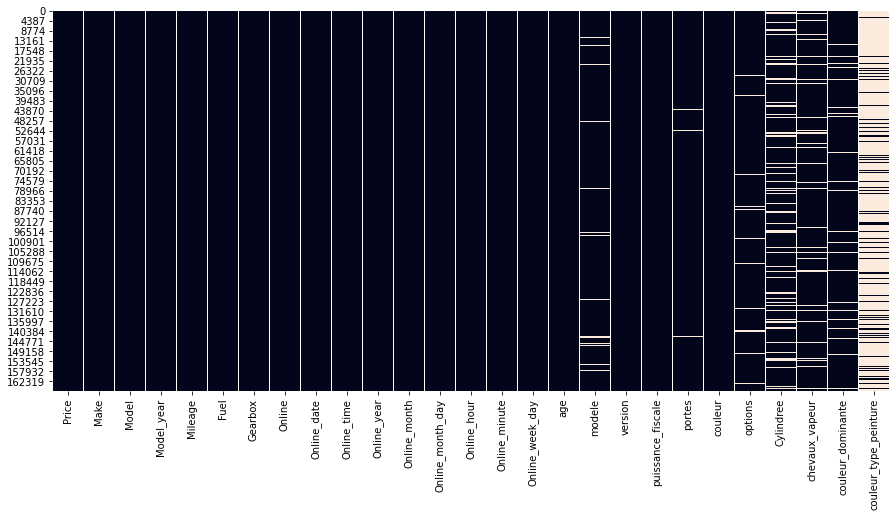

In [19]:
# Visualiser les données manquates
plt.figure(figsize=(15,7))
sns.heatmap(data_preproc.isna(), cbar=False)

In [20]:
(data_preproc.isna().sum()/data_preproc.shape[0]*100).sort_values(ascending=False)

couleur_type_peinture    79.721047
Cylindree                18.062929
chevaux_vapeur            8.921683
couleur_dominante         5.039143
options                   2.794925
modele                    2.789526
portes                    0.773269
couleur                   0.064789
Fuel                      0.000000
Online                    0.000000
Gearbox                   0.000000
Model                     0.000000
Mileage                   0.000000
Model_year                0.000000
Online_time               0.000000
Make                      0.000000
Online_date               0.000000
Online_hour               0.000000
Online_year               0.000000
Online_month              0.000000
Online_month_day          0.000000
Online_minute             0.000000
Online_week_day           0.000000
age                       0.000000
version                   0.000000
puissance_fiscale         0.000000
Price                     0.000000
dtype: float64

In [21]:
data_preproc.columns[data_preproc.isna().sum()/data_preproc.shape[0] !=0]

Index(['modele', 'portes', 'couleur', 'options', 'Cylindree', 'chevaux_vapeur',
       'couleur_dominante', 'couleur_type_peinture'],
      dtype='object')

Il y a des données manquantes dans **couleur_type_peinture**, **Cylindree**, **chevaux_vapeur**, **couleur_dominante**, **option**, **model**, **portes** et **couleur**.

## 4. Analyse univariable

### 4.1. Visualisation de la target

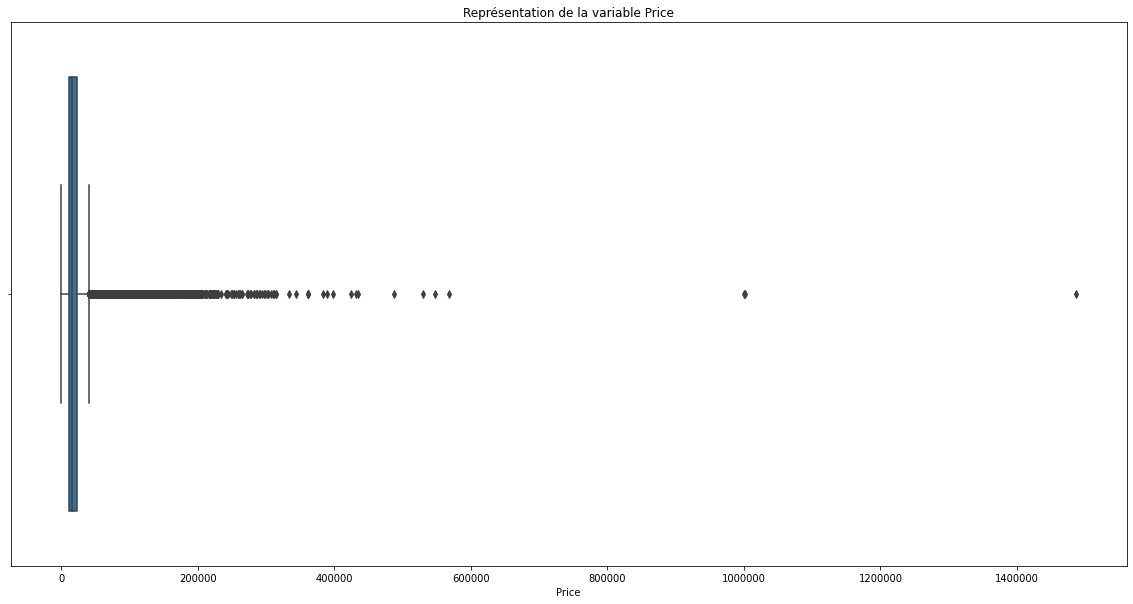

In [144]:
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Représentation de la variable Price')
sns.boxplot(data_preproc['Price'])

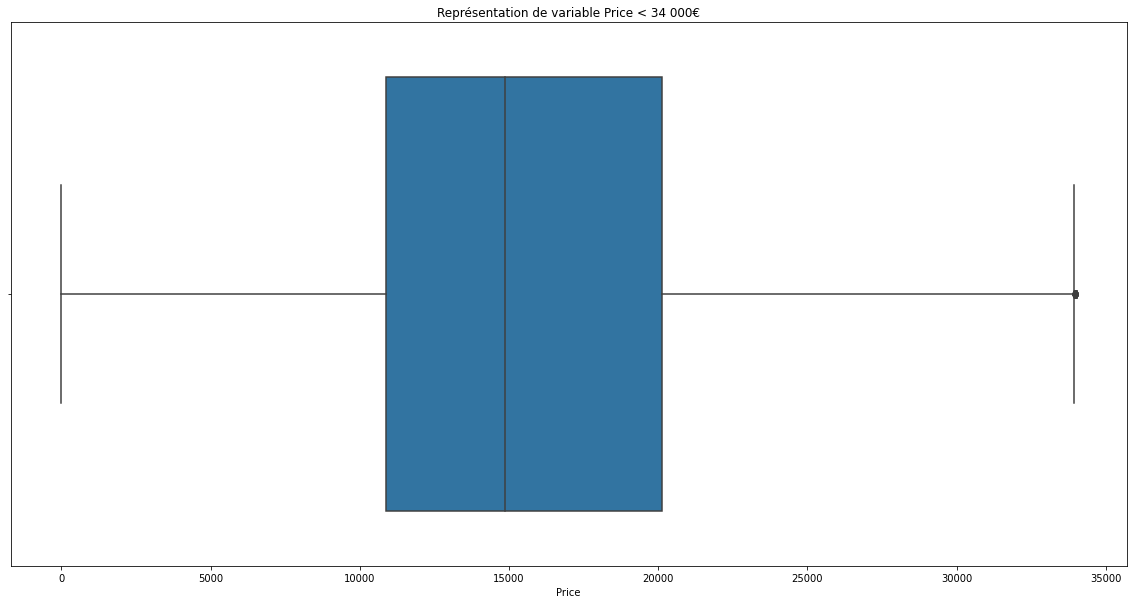

In [145]:
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Représentation de variable Price < 34 000€')
sns.boxplot(data_preproc[data_preproc['Price']<34000]['Price'])

In [24]:
print("Prix supérieur à 35.000€ : %.2f dans le dataset" %(data_preproc[data_preproc['Price']>34000].shape[0]/data_preproc.shape[0]*100))
print("Prix supérieur à 50.000€ : %.2f dans le dataset" %(data_preproc[data_preproc['Price']>50000].shape[0]/data_preproc.shape[0]*100))
print("Prix supérieur à 75.000€ : %.2f dans le dataset" %(data_preproc[data_preproc['Price']>75000].shape[0]/data_preproc.shape[0]*100))
print("Prix supérieur à 100.000€ : %.2f dans le dataset" %(data_preproc[data_preproc['Price']>100000].shape[0]/data_preproc.shape[0]*100))
print("Prix inferieur à 100€ : %.3f dans le dataset" %(data_preproc[data_preproc['Price']==1].shape[0]/data_preproc.shape[0]*100))

Prix supérieur à 35.000€ : 9.17 dans le dataset
Prix supérieur à 50.000€ : 3.38 dans le dataset
Prix supérieur à 75.000€ : 1.11 dans le dataset
Prix supérieur à 100.000€ : 0.48 dans le dataset
Prix inferieur à 100€ : 0.002 dans le dataset


**Outliers :** 
* Les prix supérieurs à 100.000€ sont à 0,5% dans le dataset (806 observation).
* Les prix à 1€ sont à 0,002 (4 observations). Des valeurs abérentes


### 4.2. Visualisation des variables numériques

<Figure size 432x288 with 0 Axes>

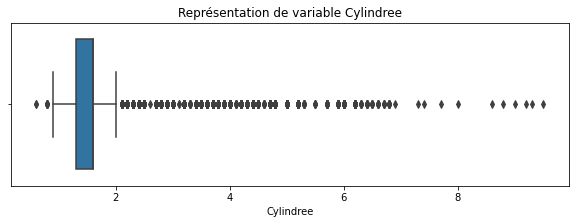

<Figure size 432x288 with 0 Axes>

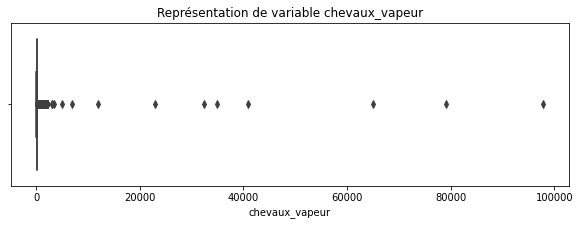

<Figure size 432x288 with 0 Axes>

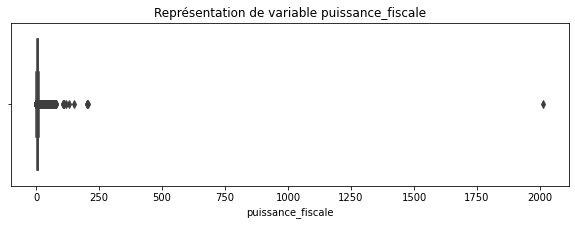

<Figure size 432x288 with 0 Axes>

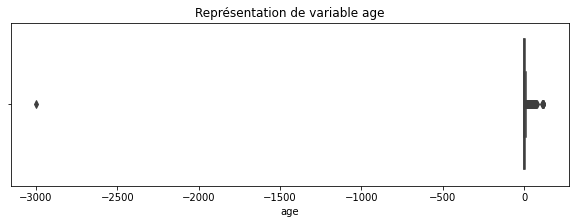

<Figure size 432x288 with 0 Axes>

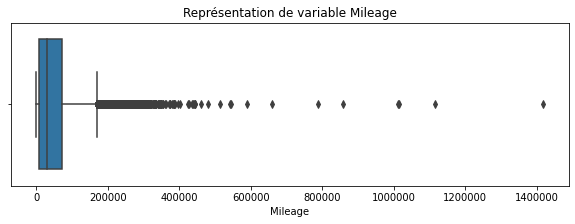

<Figure size 432x288 with 0 Axes>

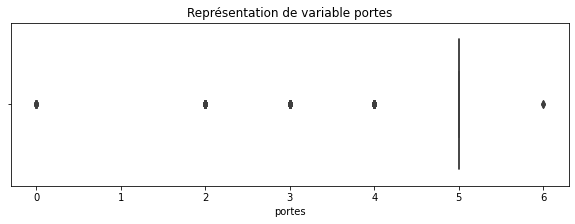

In [146]:
for col in ['Cylindree', 'chevaux_vapeur','puissance_fiscale', 'age', 'Mileage', 'portes']:
    plt.figure()
    plt.figure(figsize=(10,3))
    plt.ticklabel_format(style='plain', axis='x')
    plt.title('Représentation de variable '+col)
    sns.boxplot(data_preproc[col])

In [26]:
# Top 1 Voiture avec 2.110 ch https://www.auto-moto.com/actualite/en-chiffres/voitures-plus-puissantes-monde-classement-202908.html#item=1

print("Nombre d'observation avec Cylindree > 4 Litres: %d" %(data_preproc[data_preproc['Cylindree']>6].shape[0]))

print("Nombre d'observation avec chevaux_vapeur > 4 Litres: %d" %(data_preproc[data_preproc['chevaux_vapeur']>2110].shape[0]))

print("Nombre d'observation avec age <0 : %d" %(data_preproc[data_preproc['age']<0].shape[0]))
print("Nombre d'observation avec age > 25 ans : %d" %(data_preproc[data_preproc['age']>25].shape[0]))

print("Nombre d'observation avec puissance_fiscale > 200 ans : %d" %(data_preproc[data_preproc['puissance_fiscale']>200].shape[0]))

print("Nombre d'observation avec nombre de portes <2 : %d" %(data_preproc[data_preproc['portes']<2].shape[0]))
print("Nombre d'observation avec nombre de portes >5 : %d" %(data_preproc[data_preproc['portes']>5].shape[0]))

print("Nombre d'observation avec Mileage > 200.000km : %d" %(data_preproc[data_preproc['Mileage']>200000].shape[0]))
print("Nombre d'observation avec Mileage < 100km : %d" %(data_preproc[data_preproc['Mileage']<100].shape[0]))


Nombre d'observation avec Cylindree > 4 Litres: 137
Nombre d'observation avec chevaux_vapeur > 4 Litres: 13
Nombre d'observation avec age <0 : 1
Nombre d'observation avec age > 25 ans : 365
Nombre d'observation avec puissance_fiscale > 200 ans : 4
Nombre d'observation avec nombre de portes <2 : 17
Nombre d'observation avec nombre de portes >5 : 2
Nombre d'observation avec Mileage > 200.000km : 1557
Nombre d'observation avec Mileage < 100km : 20653


Supprimer ces outliers par la suite

### 4.3. Visualisation des variables Qualitatives

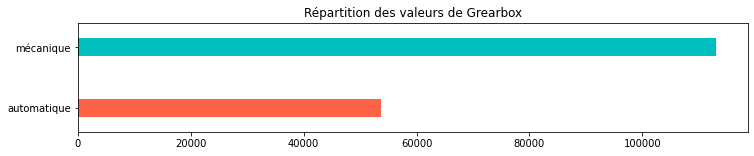

In [150]:
plt.title('Répartition des valeurs de Grearbox')
data_preproc['Gearbox'].value_counts().sort_values() \
    .plot(kind='barh', 
          color=['tomato', 'c'], 
          figsize=(12,2), 
          width=0.3 )

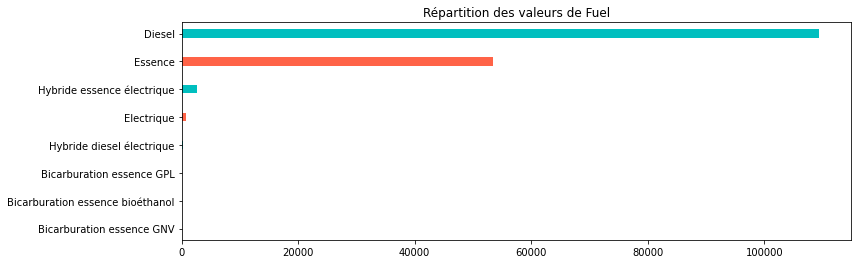

In [151]:
plt.title('Répartition des valeurs de Fuel')
data_preproc['Fuel'].value_counts().sort_values() \
    .plot(kind='barh', 
          color=['tomato', 'c'], 
          figsize=(12,4), 
          width=0.3 )

In [29]:
data_preproc['Fuel'].value_counts().sort_values()

Bicarburation essence GNV                1
Bicarburation essence bioéthanol        21
Bicarburation essence GPL               96
Hybride diesel électrique              310
Electrique                             704
Hybride essence électrique            2725
Essence                              53392
Diesel                              109446
Name: Fuel, dtype: int64

Regrouper sous **Essence** les valeurs :
- Bicarburation essence GNV, 
- Bicarburation essence bioéthanol et 
- Bicarburation essence GPL  

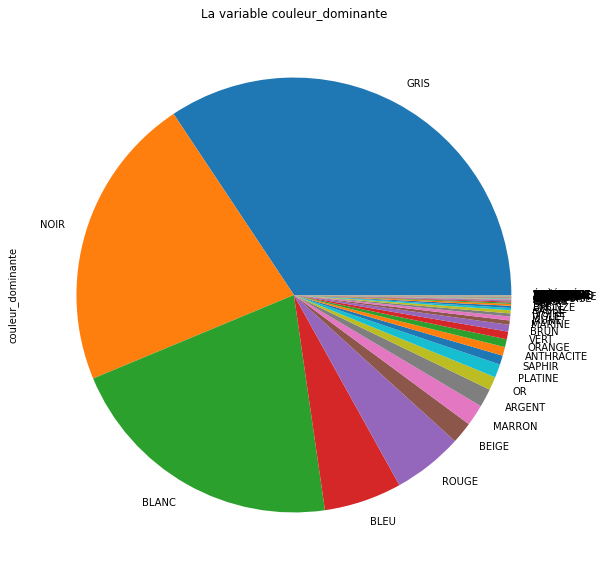

In [152]:
plt.title('La variable couleur_dominante')
data_preproc['couleur_dominante'].unique()
data_preproc['couleur_dominante'].value_counts().plot.pie(figsize=(12,10))

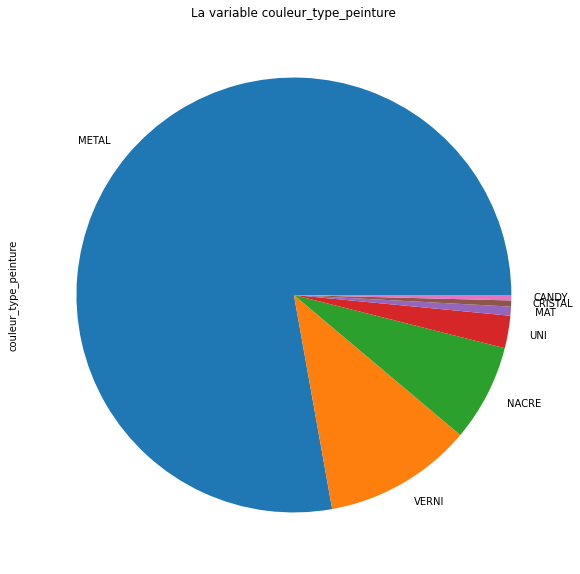

In [153]:
plt.title('La variable couleur_type_peinture')
data_preproc['couleur_type_peinture'].value_counts().plot.pie(figsize=(12,10))

In [32]:
data_preproc['couleur_dominante'].unique()
data_preproc['couleur_type_peinture'].value_counts()

METAL      26305
VERNI       3735
NACRE       2435
UNI          814
 MAT         227
CRISTAL      153
CANDY        135
Name: couleur_type_peinture, dtype: int64

In [33]:
def outliers_prrocessing(df):
    #########
    # Supression des outliers dans les variables Price, 
    # Cylindree, chevaux_vapeur, age, puissance_fiscale, porte et mileage
    #
    # Parametters: dataframe
    # Return: dataframe
    ########
    df = df[df['Price']<=100000]
    df = df[df['Price']!=1]
    
    df = df[df['Cylindree']<=6]

    df = df[df['chevaux_vapeur']<=2110]

    df = df[df['age']>=0]
    df = df[df['age']<=25]

    df = df[df['puissance_fiscale']<=200]

    df = df[df['portes']>=2]
    df = df[df['portes']<=5]

    df = df[df['Mileage']<=200000]
    
    #df.loc[df['Fuel']=="Bicarburation essence GNV", 'Fuel'] = "Essence"
    #df.loc[df['Fuel']=="Bicarburation essence bioéthanol", 'Fuel'] = "Essence"
    #df.loc[df['Fuel']=="Bicarburation essence GPL", 'Fuel'] = "Essence"

    return df

In [34]:
data_outliers = outliers_prrocessing(data_preproc.copy())

## 5. Analyse bi-variable par rapport à la target

### 5.1. Les variables numériques

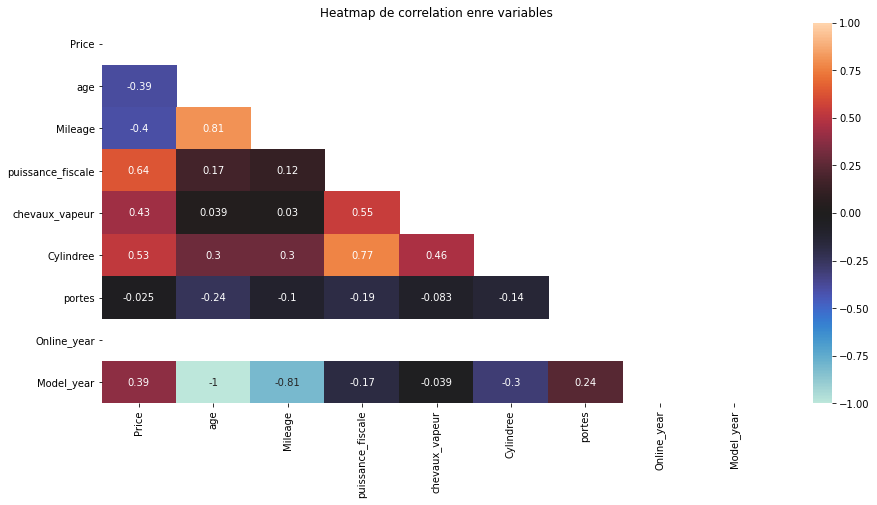

In [155]:
plt.figure(figsize=(15,7))
corr = data_outliers[['Price', 'age', 'Mileage', 'puissance_fiscale', 'chevaux_vapeur', 'Cylindree', 'portes',
                     'Online_year', 'Model_year']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.title('Heatmap de correlation enre variables')
sns.heatmap(corr, mask=mask, annot = True, vmin=-1, vmax=1, center= 0)

* Il y a correlation positive entre **Price** d'un côté et **puissance_fiscale**, **chevaux_veapeur**, **Cylindree**, et **Model_year** (pas très importante) de l'autre côté.
* Il y a une correlation négative entre **Price** et **age** / **Mileage**.

### 5.2. La variable 'Fuel'

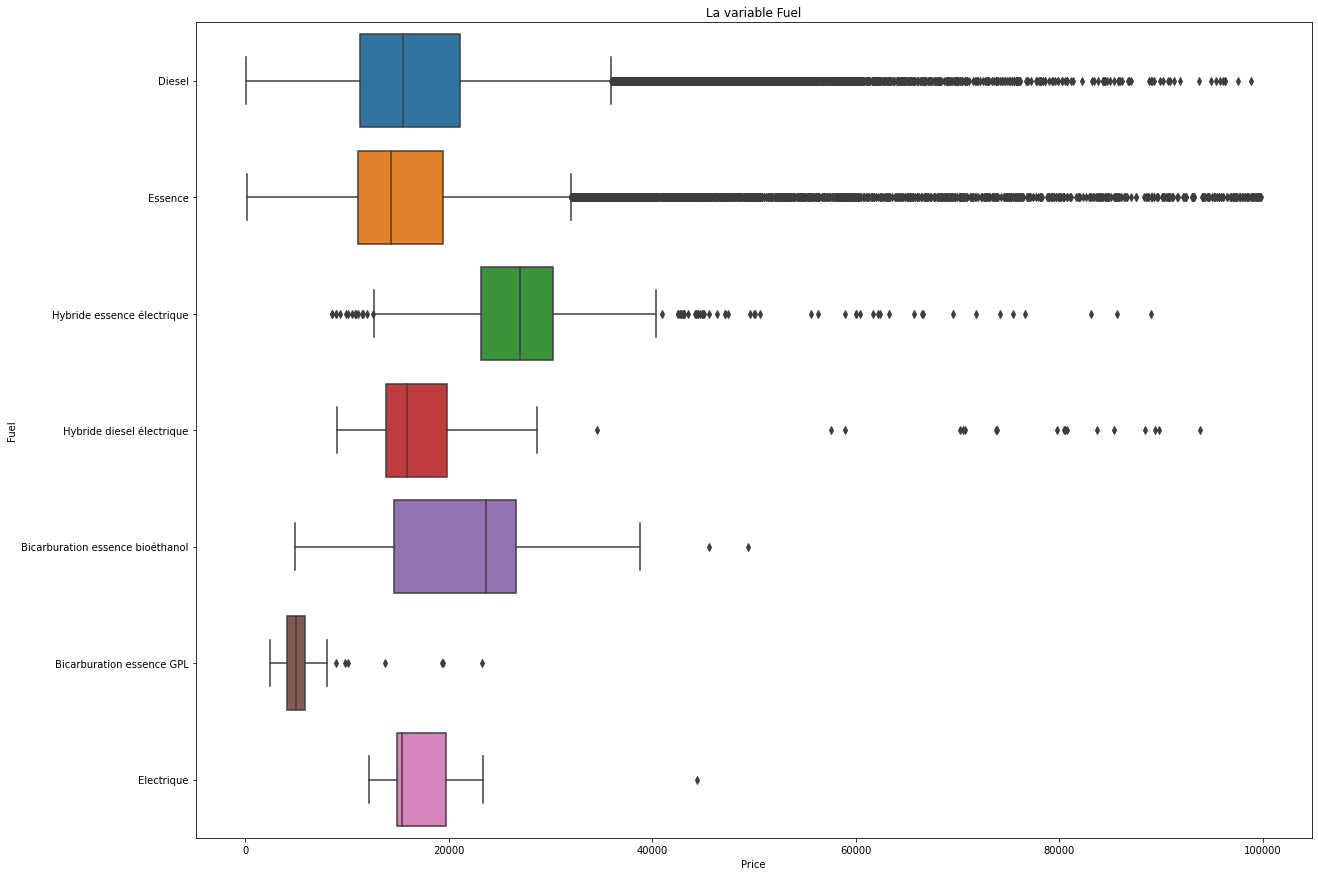

In [156]:
plt.figure(figsize=(20,15))
plt.title('La variable Fuel')
sns.boxplot('Price', 'Fuel', data=data_outliers)

**Les vehicules 'Hybride essence électrique' sont les plus chers en moyenne**

### 5.3. La variable 'Gearbox'

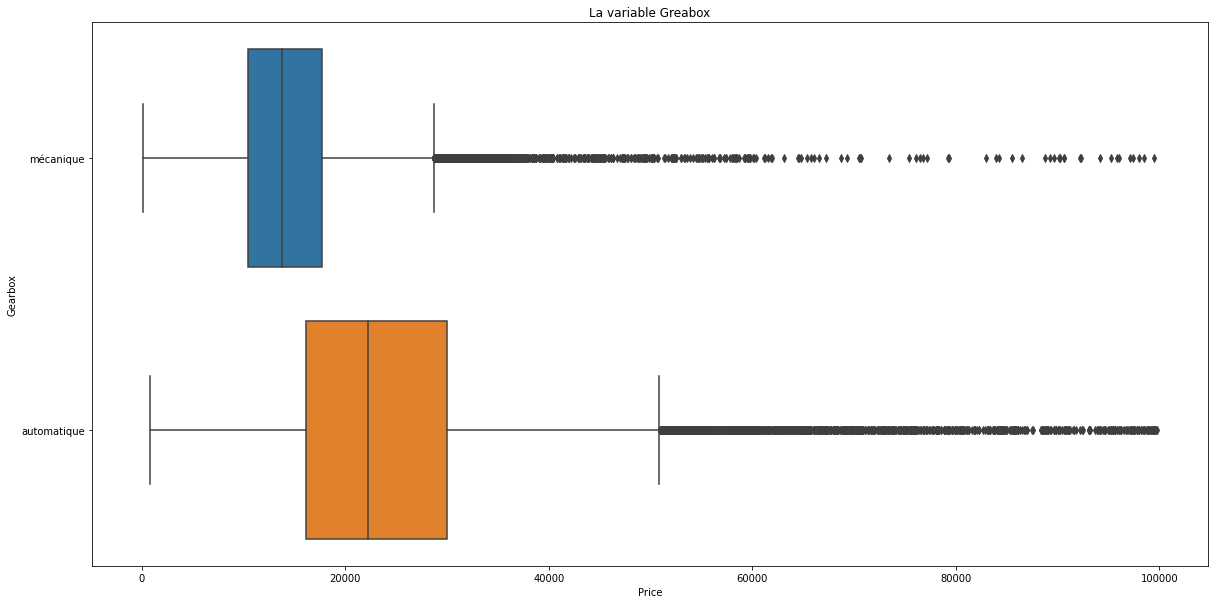

In [157]:
plt.figure(figsize=(20,10))
plt.title('La variable Greabox')
sns.boxplot('Price', 'Gearbox', data=data_outliers)

**Les vehicules 'automatique' sont les plus chers en moyenne**

## 6. Modelisation

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn import metrics

### 6.1. Définition de la metrique MAPE

In [42]:
# Définition de la metrique MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 6.2. Définition des transformations de variables

In [112]:
## inspéré de : https://angelosalton.github.io/2019/01/29/predicting-car-prices-with-scikit-learn.html

def preproc_config(categorical_features, numeric_features, num_strat='median'):
    ######
    # Traitement des valeurs manquantes
    # Application de OneHotEncoder sur les variables qualitatives
    # Application de la standardisation sur les variable quantitatives (numériques)
    # Parametters: categorical_features, numeric_features, num_strat
    # return: ColumnTransformer
    ######
    
    # 1. numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=num_strat)),
        ('scaler', StandardScaler())
        ])
    # 2. quantitaitive features
    # run once on full dataset to get all category values
    #temp = ColumnTransformer([('cat', OneHotEncoder(), categorical_features)]).fit(X)
    #cats = temp.named_transformers_['cat'].categories_

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(#categories=cats,
                                 sparse=False, handle_unknown='ignore'))
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

### 6.3. Selection d'un échantillon

Selection d'un sous-ensemble d'observation afin de gagner en temps pendant l'entrainement de différents modèles (30% du dataset initial)

In [44]:
#data_sample = data_preproc.sample(frac=.3, random_state=42)
data_sample = data_outliers.sample(frac=.3, random_state=42)
data_sample.shape, data_outliers.shape

((38640, 27), (128800, 27))

### 6.4. Selection des features

In [102]:
target = 'Price'

# categorical features
categorical_features = ['Fuel', 'Gearbox', 'Make', 'Model', 'version']

# numerical features
numeric_features = ['Mileage', 'age', 'puissance_fiscale', 'portes', 'Cylindree','chevaux_vapeur']

In [103]:
X = data_sample[categorical_features+numeric_features].copy()
y = data_sample[target].values.copy() # prices$

# generation du train et test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30912, 11), (7728, 11), (30912,), (7728,))

In [104]:
## Initialisation du ColumnTransformer pour la transformation des données
preprocessor = preproc_config(categorical_features, numeric_features)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Mileage', 'age', 'puissance_fiscale',
                                  'portes', 'Cylindree', 'chevaux_vapeur']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(categories=[array(['Bicarbur...
       'XV', 'YARIS', 'YETI', 'YPSILON', 'Z3', 'Z4', 'ZAFIRA',
       'ZAFIRA TOURER'], dtype=object),
                                                                            array(['"1.2 TCE 130 INTENS BOSE ""NEUF"""',
       '"IV 1.2 TCE 130  INTENS ""BOSE"""',
       '"IV 1.5 DCI 110  INTENS ""BOSE"" EDC"', ...,
       'X-PERIENCE 2.0 TDI 150 DSG7 4DRIVE',
       'X-PERIENCE 2.0 TDI S/S 150  DSG7 4DRIVE',
       'XCELLENCE 1.0 ECOTSI 95   START/STOP 5CV 112G/KM'], dtype=object)],
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Fuel', 'Gearbox', 'Make', 'Model',
                                  'version'])])

### 6.5. Entrainement de plusieurs modèles

In [56]:
# Liste des modèles à entrainer
models = [DummyRegressor(),
          KNeighborsRegressor(),
          linear_model.Lasso(),
          linear_model.Ridge(),
          linear_model.ElasticNet(),
          ensemble.GradientBoostingRegressor(),
          ensemble.RandomForestRegressor(),
          ensemble.ExtraTreesRegressor()]

models_names = ['Dummy','K-nn', 'Lasso','Ridge','Elastic','Boost','Forest','Extra']

In [57]:
# Liste des métriques pour chaque modèle
mape = []
scores = []

# Utilisation d'un pileline : Transformation de données --> entrainement d'un modèle sur la sortie
for model in models:
    pipe = Pipeline([
    ('preprocessor', preprocessor), # Transformation de données
    ('model', model) # entrainement d'un modèle
    ])
    fits = pipe.fit(X_train,y_train)
    mape.append(mean_absolute_percentage_error(y_test, fits.predict(X_test)))
    scores.append(metrics.r2_score(y_test, fits.predict(X_test)))


In [61]:
result_all_models = pd.DataFrame(data=list(zip(models_names, mape, scores)), columns=['model', 'mape', 'scores'])
result_all_models

,model,mape,scores
0,Dummy,51.116087,-0.000008
1,K-nn,14.623610,0.926501
2,Lasso,21.654910,0.872792
3,Ridge,16.046446,0.915186
4,Elastic,27.645226,0.695143
5,Boost,14.040848,0.905655
6,Forest,9.215177,0.950086
7,Extra,9.699340,0.954719


Text(0, 0.5, 'Score')

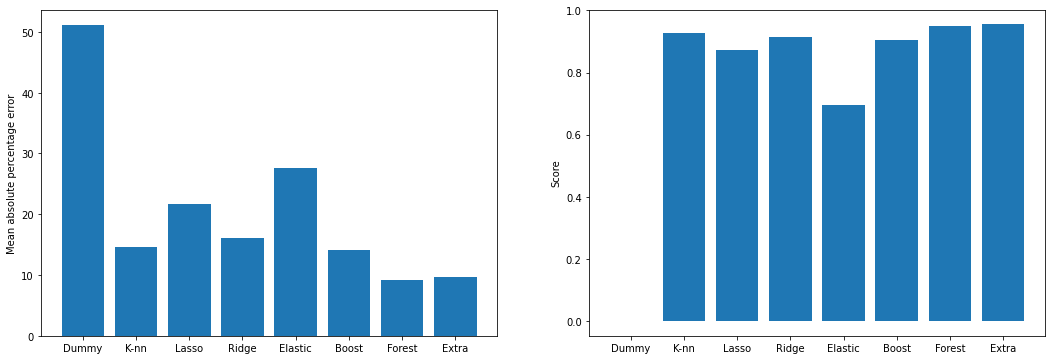

In [63]:
f, (ax1, ax2 ) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(18,6))
ax1.bar(result_all_models['model'], result_all_models['mape'])
ax1.set_ylabel('Mean absolute percentage error')

ax2.bar(result_all_models['model'], result_all_models['scores'])
ax2.set_ylabel('Score')

**Le meilleur modèle en terme de minimisation de la MAPE est le RandomForest avec une MAPE = 9,22%**

### 6.6. Ajout de la feature 'couleur_dominante'

In [113]:
target = 'Price'

# categorical features
categorical_features = ['Fuel', 'Gearbox', 'Make', 'Model', 'version', 'couleur_dominante']

# numerical features
numeric_features = ['Mileage', 'age', 'puissance_fiscale', 'portes', 'Cylindree','chevaux_vapeur']

X = data_sample[categorical_features+numeric_features].copy()
y = data_sample[target].values.copy() # prices$

# generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Initialisation du ColumnTransformer pour la transformation des données
preprocessor = preproc_config(categorical_features, numeric_features)

In [114]:
model = ensemble.RandomForestRegressor()

models_names = ['Forest']

mape = []
scores = []

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
    ])
fits = pipe.fit(X_train,y_train)
mape.append(mean_absolute_percentage_error(y_test, fits.predict(X_test)))
scores.append(metrics.r2_score(y_test, fits.predict(X_test)))

In [118]:
result_RF_couleur = pd.DataFrame(data=list(zip(models_names, mape, scores)), columns=['model', 'mape', 'scores'])
result_RF_couleur

,model,mape,scores
0,Forest,9.232104,0.950218


**La couleur n'est pas determinante dans la prédiction du prix**

### 6.7. Hyper-paramètre n_estimators=100

In [65]:
model = ensemble.RandomForestRegressor(n_estimators=100)

models_names = ['Forest']

mape = []
scores = []

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
    ])
fits = pipe.fit(X_train,y_train)
mape.append(mean_absolute_percentage_error(y_test, fits.predict(X_test)))
scores.append(metrics.r2_score(y_test, fits.predict(X_test)))


In [68]:
result_RF_100 = pd.DataFrame(data=list(zip(models_names, mape, scores)), columns=['model', 'mape', 'scores'])
result_RF_100

,model,mape,scores
0,Forest,9.200556,0.950516


**La performance de RandomForest peut être améliorée en jouant sur les hyper-paramères du modèle**

## 7. Conclusion

* **Données manquantes :**
    * Il y a des données manquantes dans couleur_type_peinture, Cylindree, chevaux_vapeur, couleur_dominante, optioon, model, portes et couleur. 
    * **Croiser avec des données externes afin de réduire le pourcentage des valeurs manquantes et enrichir avec d'autres données**

* **Variable Target : 'Price'**
    * **Outliers :** 
        * Les prix supérieurs à 100.000€ sont à 0,5% dans le dataset (806 observation).
        * Les prix à 1€ sont à 0,002 (4 observations) => valeurs abérentes.
* **Les variables numériques :**
    * **Outliers :** 
        * Cylindree > 4 Litres: 137 observations,
        * chevaux_vapeur > 4 Litres: 13 observations,
        * age < 0 : 1 observation,
        * age > 25 ans : 365 observations,
        * puissance_fiscale > 200 ans : 4 observations,
        * nombre de portes <2 : 17 observations,
        * nombre de portes >5 : 2 observations,
        * Mileage > 200 000km : 1557 observations,
        * Mileage < 100km : 20653 observations (Ne pas supprimer),
* **Analyse bi-variable :**
    * Il y a une correlation positive entre **Price** d'un côté et **puissance_fiscale**, **chevaux_veapeur**, **Cylindree**, et **Model_year** (pas très importante) de l'autre côté.
    * Il y a une correlation négative entre **Price** et **age** / **Mileage**.
    * Les vehicules 'Hybride essence électrique' sont les plus chers en moyenne
    * Les vehicules 'automatique' sont les plus chers en moyenne
* **Modelisation :**
    * RandomForest est le meilleur modèle en terme de minimisation de la MAPE (9.22%). 
    * La performance de RandomForest peut être améliorée en jouant sur les hyper-paramères du modèle.

## 8. Prochaines étapes 
Afin d'améliorer les performances du modèle de prédiction :
* Rechereche et collecte de données externes pour :
    * réduire le taux des valeurs manquantes,
    * corriger les valeurs aberante, 
    * ajouter d'autres variables telles que les prix neuf des vehicules,...etc.
* Croisement des données externes avec les données Data_cars et réalisation du data engineering.
* Entrainement du modèle RandomFroest sur les nouvelles données